##### Import

In [16]:
import os
import sys
import warnings
import gc
from pathlib import Path

import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

#### Test on unseen data

In [17]:
from utils import rank_stocks_and_quantile

top = 250
DATA_STORE = Path(f'data/250_dataset.h5')
key = dataset_key = '/data/YEAR_20220906_20230811'
label = 'TARGET_ret_fwd_frac_order' # parameters

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # print(store.keys())
datetime_level = 0  # Assuming the datetime is the first level
if dataset.index.levels[datetime_level].tz is None:
    localized_level = dataset.index.levels[datetime_level].tz_localize('UTC')
    dataset.index = dataset.index.set_levels(localized_level, level=datetime_level)


# Applying the rank_stocks_and_quantile function to the dataset
dataset_ranked = rank_stocks_and_quantile(dataset, TARGET_col=label)
print(dataset_ranked.info())

# Get unique dates and sort them
unique_dates = dataset_ranked.index.get_level_values('date').unique().sort_values()
cols = dataset_ranked.columns.tolist()

# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]

# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]

# Adjust for the look-ahead gap and get test dates
look_ahead = 1
test_dates = unique_dates[-21*9:]

# Create the test_data DataFrame using cross-section (xs) for MultiIndex slicing
test_data = dataset_ranked[dataset_ranked.index.isin(test_dates, level='date')]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59607 entries, (Timestamp('2022-09-06 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2023-08-11 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 142.6+ MB
None


In [18]:
import lightgbm as lgb
import pandas as pd

def predict_and_format(model_path: str, test_data: pd.DataFrame, features: list, label: str) -> pd.DataFrame:
    """
    Load a LightGBM model from the specified path, make predictions on the test data, and format the results.

    Parameters:
    - model_path: Path to the saved LightGBM model.
    - test_data: Test dataframe containing features and labels.
    - features: List of feature column names.
    - label: Column name of the label.

    Returns:
    - preds: Formatted dataframe with predictions and selected feature data.
    """

    # Load the model
    best_model = lgb.Booster(model_file=model_path)

    # Extract features and labels
    test_features = test_data[features]
    test_labels = test_data[label]

    # Make predictions
    y_pred = best_model.predict(test_features)

    # Format the predictions dataframe
    preds = test_labels.reset_index(name='actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

    # Rename columns to add 'feature_' prefix
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    test_data_renamed = test_data.rename(columns=rename_dict)

    # Join with selected feature data
    preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                      on=['ticker', 'date'], 
                                      how='left')

    # Filter columns of interest
    preds = preds[['date', 'ticker', 'actual', 'predicted'] + new_col_names].set_index(['ticker', 'date'])
    
    return preds

model_path = "/home/sayem/Desktop/Project/models/_data_YEAR_20130102_20141208_best_model.txt"
preds = predict_and_format(model_path, test_data, features, label)

In [19]:
preds

,,actual,predicted,FEATURE_open,FEATURE_high,FEATURE_low,FEATURE_close,FEATURE_volume
ticker,date,,,,,,,
AA,2022-11-09 00:00:00+00:00,8.907696,0.252502,42.529999,42.745399,40.340000,40.680000,4181219.0
AAL,2022-11-09 00:00:00+00:00,2.725104,-0.019548,14.120000,14.338100,13.970000,13.980000,21047165.0
AAPL,2022-11-09 00:00:00+00:00,18.812790,0.688528,138.500000,138.550003,134.593307,134.869995,74917794.0
ABBV,2022-11-09 00:00:00+00:00,14.840831,0.558681,148.589996,150.570007,147.039993,147.619995,4573740.0
ABT,2022-11-09 00:00:00+00:00,11.859546,0.281577,99.910004,101.273300,99.250000,99.459999,5339555.0
...,...,...,...,...,...,...,...,...
WYNN,2023-08-11 00:00:00+00:00,15.163733,0.625788,103.989998,103.989998,99.610001,100.550003,3148065.0
X,2023-08-11 00:00:00+00:00,4.126132,0.114958,22.330000,22.730000,22.261000,22.719999,6708229.0
XOM,2023-08-11 00:00:00+00:00,12.413455,0.449642,110.370003,112.070000,110.050003,111.830002,14047044.0


In [20]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [21]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
papermill_era_scores = daily_sharpe_ratios = (daily_correlations - \
    mean_daily_correlation) / std_daily_correlation

papermill_era_scores_df = papermill_era_scores.to_frame()
papermill_era_scores_df.columns = papermill_era_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_era_scores_df, display=True)

papermill_era_scores_list = papermill_era_scores.tolist()
sb.glue("papermill_era_scores", papermill_era_scores_list)


,0
date,
2022-11-09 00:00:00+00:00,-0.128913
2022-11-10 00:00:00+00:00,-0.419581
2022-11-11 00:00:00+00:00,0.209572
2022-11-14 00:00:00+00:00,-0.022799
2022-11-15 00:00:00+00:00,-0.286119
2022-11-16 00:00:00+00:00,-0.175747
2022-11-17 00:00:00+00:00,0.323547
2022-11-18 00:00:00+00:00,-0.011991
2022-11-21 00:00:00+00:00,0.188448


In [22]:
import matplotlib.pyplot as plt
from pathlib import Path

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Add horizontal line at y=0
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Define directory and clean up the dataset_key
plot_dir = Path("plots")
clean_dataset_key = dataset_key.replace("/", "_")

# Create the plots directory if it doesn't exist
plot_dir.mkdir(exist_ok=True)

# Define the save path for the plot using the cleaned key
plot_path = plot_dir / f"sharpe_ratios_{clean_dataset_key}.png"

# Save the plot
plt.savefig(plot_path)
plt.close()

# Convert the path to string and glue it
papermill_plot_path_str = str(plot_path)
sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)

'plots/sharpe_ratios__data_YEAR_20220906_20230811.png'

In [23]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 97.452% (p-value: 0.00000000%)


0.9745198328913076

0.0

In [24]:
preds.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49715 entries, ('AA', Timestamp('2022-11-09 00:00:00+0000', tz='UTC')) to ('ZTS', Timestamp('2023-08-11 00:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          49715 non-null  float32
 1   predicted       49715 non-null  float64
 2   FEATURE_open    49715 non-null  float32
 3   FEATURE_high    49715 non-null  float32
 4   FEATURE_low     49715 non-null  float32
 5   FEATURE_close   49715 non-null  float32
 6   FEATURE_volume  49715 non-null  float64
dtypes: float32(5), float64(2)
memory usage: 1.9+ MB


In [25]:
def add_quantile_signals(df, buy_threshold=0.95, sell_threshold=0.05):
    buy_cutoff = df['predicted'].quantile(buy_threshold)
    sell_cutoff = df['predicted'].quantile(sell_threshold)
    
    df['signal'] = 0  # Neutral by default
    df.loc[df['predicted'] >= buy_cutoff, 'signal'] = 1  # Buy
    df.loc[df['predicted'] <= sell_cutoff, 'signal'] = -1  # Sell
    return df

# Apply the function
preds = add_quantile_signals(preds, \
    buy_threshold=0.95, sell_threshold=0.05)

In [26]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49715 entries, ('AA', Timestamp('2022-11-09 00:00:00+0000', tz='UTC')) to ('ZTS', Timestamp('2023-08-11 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          49715 non-null  float32
 1   predicted       49715 non-null  float64
 2   FEATURE_open    49715 non-null  float32
 3   FEATURE_high    49715 non-null  float32
 4   FEATURE_low     49715 non-null  float32
 5   FEATURE_close   49715 non-null  float32
 6   FEATURE_volume  49715 non-null  float64
 7   signal          49715 non-null  int64  
dtypes: float32(5), float64(2), int64(1)
memory usage: 2.3+ MB


##### Backtesting

In [27]:
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanalyzers
from pypfopt import EfficientFrontier, expected_returns, risk_models
import pyfolio as pf
import yfinance as yf

# Data Class for Predictions
class PandasPredictions(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('signal', -1),
        ('open', 'FEATURE_open'),
        ('high', 'FEATURE_high'),
        ('low', 'FEATURE_low'),
        ('close', 'FEATURE_close'),
        ('volume', 'FEATURE_volume')
    )

# Function to optimize weights using PyPortfolioOpt
def optimize_weights(datas):
    prices = {}
    
    for data in datas:
        s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
        prices[data._name] = s

    df = pd.DataFrame(index=prices[next(iter(prices))].index)

    for ticker, s in prices.items():
        df = df.merge(s, left_index=True, right_index=True, how='left').rename(columns={s.name: ticker})

    df = df.dropna()

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
    weights = ef.max_sharpe(risk_free_rate=0.005)
    return ef.clean_weights()

# Strategy Class
class TradeAndRebalanceStrategy(bt.Strategy):
    lines = ('benchmark',)  # Added benchmark line here
    
    def __init__(self):
        self.rebalance_days = 0
        self.max_loss = -0.15
        self.start_cash = self.broker.get_cash()
        self.benchmark_data = self.getdatabyname("S&P 500")

    def log(self, txt, dt=None):
        ''' Logging function for the strategy. It logs the date and the message provided. '''
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")

    def next(self):
        # Update benchmark line at each step
        self.lines.benchmark[0] = self.benchmark_data.close[0] 

        if (self.broker.get_cash() - self.start_cash) / self.start_cash <= self.max_loss:
            return
        
        for data in self.datas:
            if data._name == "S&P 500":  # Skip the benchmark
                continue
            if data.signal[0] == 1:
                self.buy(data)
            elif data.signal[0] == -1:
                self.sell(data)

        if self.rebalance_days == 0:
            weights = optimize_weights([data for data in self.datas if data._name != "S&P 500"])
            for asset, weight in weights.items():
                if weight > 0.30:
                    weights[asset] = 0.30
            
            for data in self.datas:
                if data._name == "S&P 500":
                    continue
                if data._name in weights:
                    self.order_target_percent(data, target=weights[data._name])
                else:
                    self.close(data)
            self.rebalance_days = 20
        else:
            self.rebalance_days -= 1

        benchmark_return = (self.benchmark_data.close[0] - \
            self.benchmark_data.close[-1]) / self.benchmark_data.close[-1]
        self.log(f"Benchmark Return: {benchmark_return * 100:.2f}%")

# Fetch S&P 500 data using yfinance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

# Assume preds is defined somewhere earlier in your code
start_date = preds.index.get_level_values(1).min()
end_date = preds.index.get_level_values(1).max()
sp500_data = fetch_data('^GSPC', start_date, end_date)

# Convert it into Backtrader format
benchmark = bt.feeds.PandasData(dataname=sp500_data, name="S&P 500")

cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')
cerebro.adddata(benchmark)

your_data_dict = {ticker: preds.xs(ticker) for ticker in preds.index.get_level_values(0).unique()}
for ticker, data_df in your_data_dict.items():
    data = PandasPredictions(dataname=data_df, name=ticker)
    cerebro.adddata(data)

cerebro.addstrategy(TradeAndRebalanceStrategy)
results = cerebro.run()

# Performance Analysis
returns, positions, transactions, gross_lev \
    = results[0].analyzers.pyfolio.get_pf_items()

[*********************100%***********************]  1 of 1 completed


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 29 06:25:48 PM: Your problem has 251 variables, 5 constraints, and 0 parameters.
(CVXPY) Sep 29 06:25:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 29 06:25:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 29 06:25:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 29 06:25:49 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 29 06:25:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

                           Strategy
-------------------------  ----------
Start Period               2022-11-09
End Period                 2023-08-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          15.88%
CAGR﹪                     14.46%

Sharpe                     1.26
Prob. Sharpe Ratio         86.49%
Smart Sharpe               1.17
Sortino                    1.99
Smart Sortino              1.84
Sortino/√2                 1.41
Smart Sortino/√2           1.3
Omega                      1.22

Max Drawdown               -7.48%
Longest DD Days            105
Volatility (ann.)          16.68%
Calmar                     1.93
Skew                       0.29
Kurtosis                   0.17

Expected Daily %           0.08%
Expected Monthly %         1.48%
Expected Yearly %          7.65%
Kelly Criterion            9.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.65%
Expected Shortfall (cVaR)  -1.65%

Max Consecutive Wins       8

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-02,2023-03-13,2023-05-17,105,-7.475824,-7.247102
2,2022-12-01,2023-01-05,2023-01-24,55,-6.542422,-5.870432
3,2023-07-05,2023-07-07,2023-07-13,9,-3.307500,-2.513249
4,2023-06-16,2023-06-26,2023-06-29,14,-2.692154,-2.199517
5,2023-05-19,2023-05-24,2023-05-25,7,-2.182776,-1.537757


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


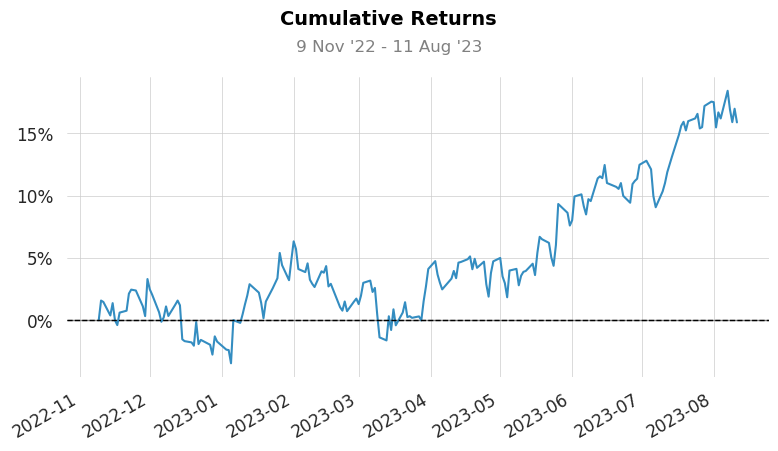

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


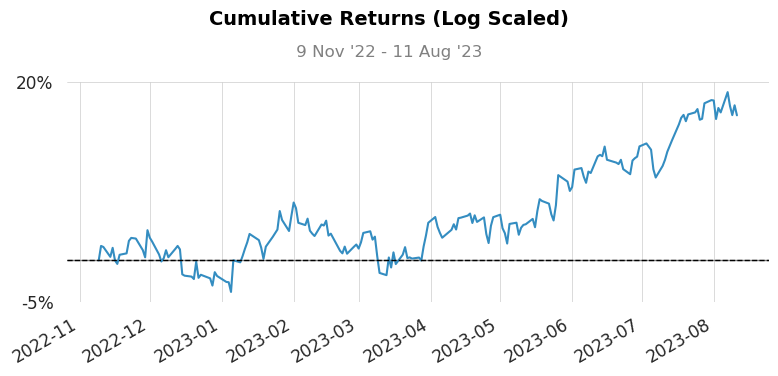

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


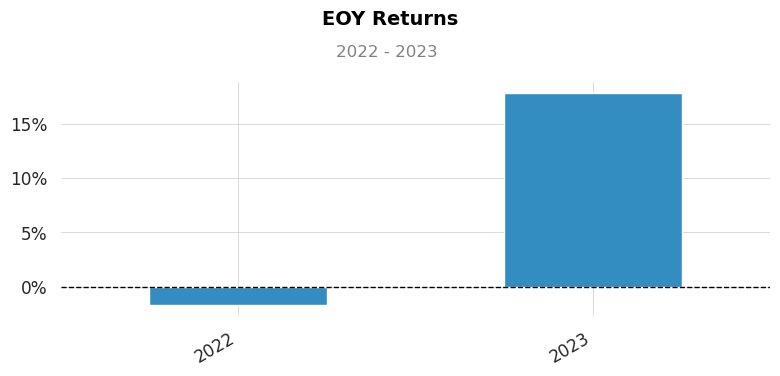

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


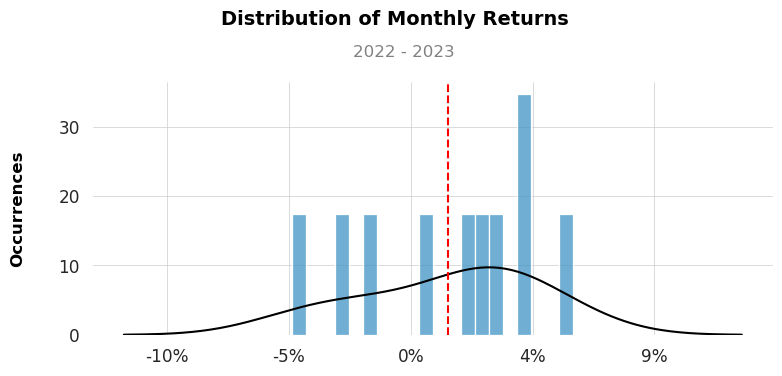

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


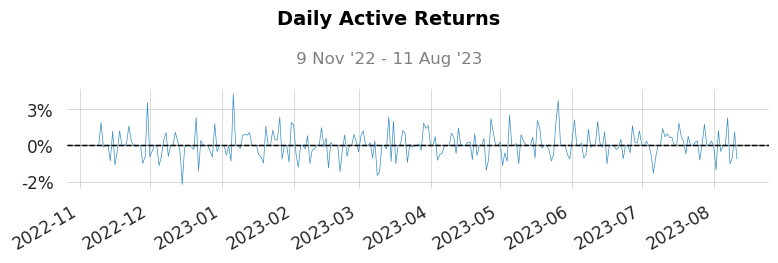

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


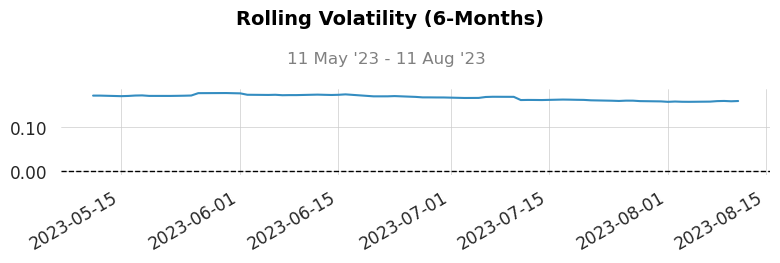

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


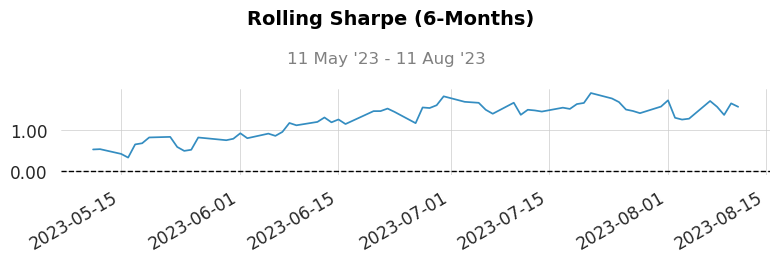

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


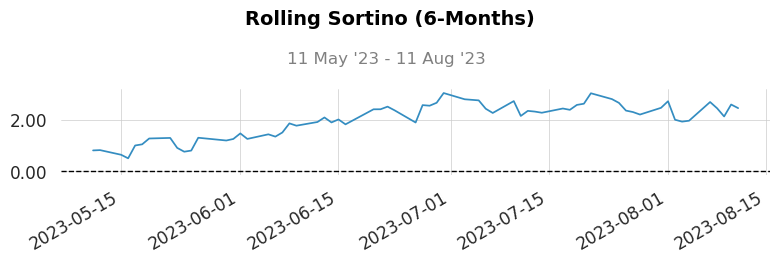

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


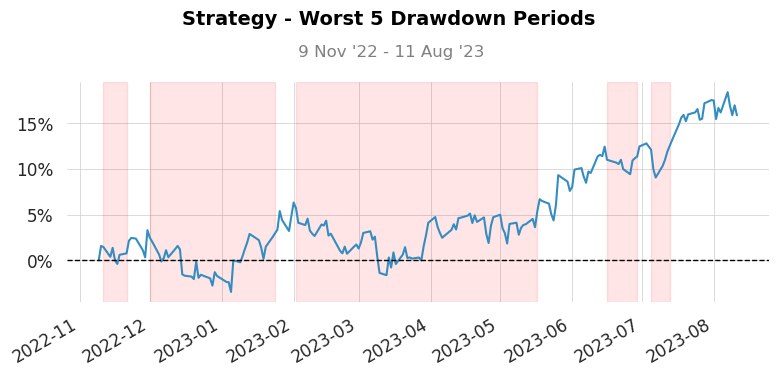

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


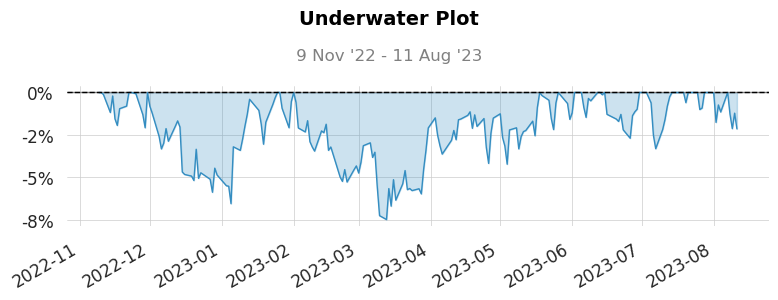

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


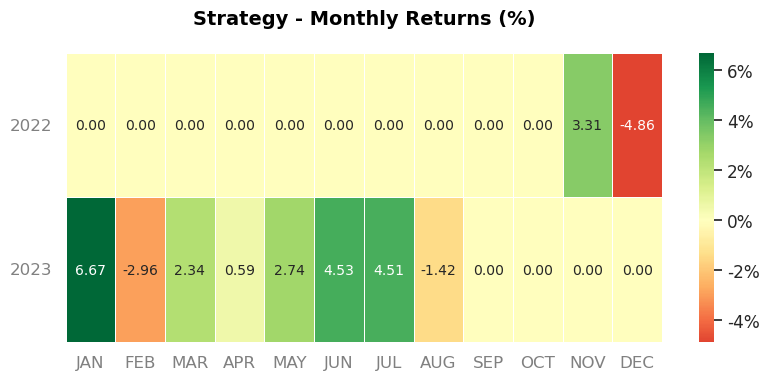

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


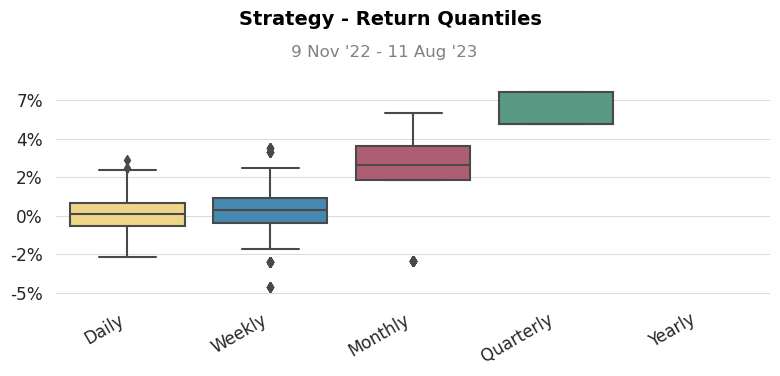

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


                    Strategy
------------------  ----------
Start Period        2022-11-09
End Period          2023-08-11
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   15.88%
CAGR﹪              14.46%

Sharpe              1.26
Prob. Sharpe Ratio  86.49%
Sortino             1.99
Sortino/√2          1.41
Omega               1.22

Max Drawdown        -7.48%
Longest DD Days     105

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.72

Payoff Ratio        1.12
Profit Factor       1.22
Common Sense Ratio  1.44
CPC Index           0.71
Tail Ratio          1.18
Outlier Win Ratio   3.36
Outlier Loss Ratio  2.41

MTD                 -1.42%
3M                  11.88%
6M                  12.87%
YTD                 17.89%
1Y                  15.88%
3Y (ann.)           14.46%
5Y (ann.)           14.46%
10Y (ann.)          14.46%
All-time (ann.)     14.46%

Avg. Drawdown       -2.47%
Avg. Drawdown Days  15
Recovery Factor     2.11
Ulcer Index         0.03
Serenity Index      

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


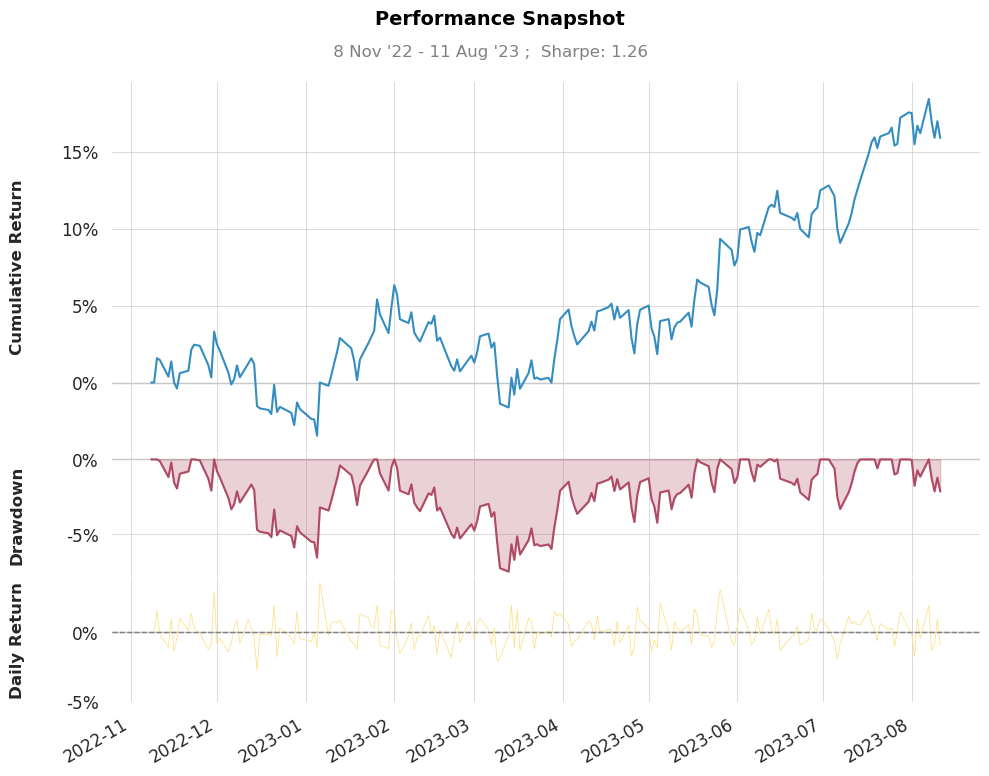

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


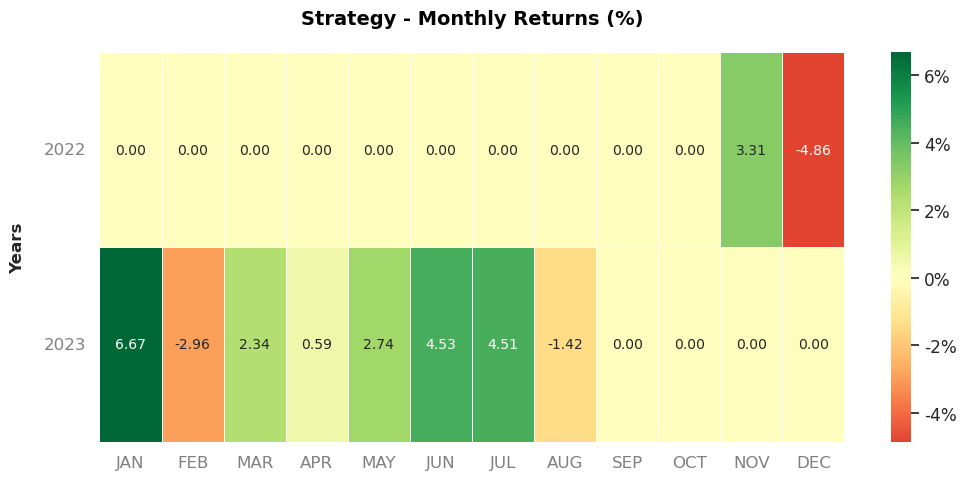

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


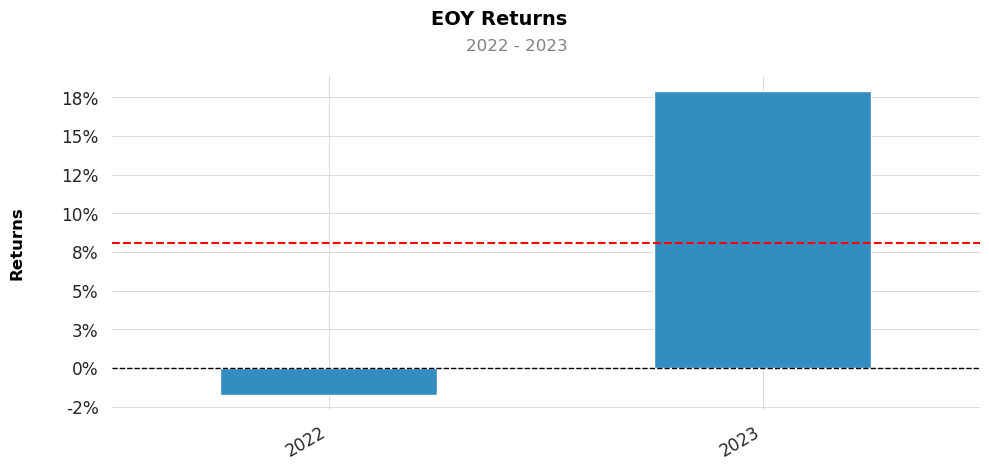

In [28]:
import quantstats as qs
import matplotlib.pyplot as plt

# You would replace this with loading your own returns data
# returns = ...

# Print extended, in-depth performance stats
qs.reports.full(returns)

# Or only the metrics
qs.reports.metrics(returns)

# Plotting various graphs
qs.plots.snapshot(returns, title='Performance Snapshot')
qs.plots.monthly_heatmap(returns)
qs.plots.yearly_returns(returns)

plt.show()
